In [31]:
# Import semua library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('default')
sns.set_palette("husl")

In [32]:
# Load dataset
print("=" * 60)
print("STEP 1: LOAD DAN EKSPLORASI DATA")
print("=" * 60)

df = pd.read_csv('all-dataset.csv')

# Display basic info
print("📁 INFO DATASET:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\n" + "-" * 40)

STEP 1: LOAD DAN EKSPLORASI DATA
📁 INFO DATASET:
Shape: (505, 11)
Columns: ['Provinsi', 'Kabupaten/Kota', 'Persentase Penduduk Miskin (P0)', 'Rata-rata Lama Sekolah', 'Pengeluaran per Kapita', 'Umur Harapan Hidup (UHH)', 'Indeks Pembangunan Manusia (IPM)', 'Tingkat Pengangguran Terbuka (TPT) - Agustus', 'Tingkat Partisipasi Angkatan Kerja (TPAK) - Agustus', 'Rumah Tangga yang Memiliki Akses Terhadap Sanitasi Layak', 'Rumah Tangga yang Memiliki Akses Terhadap Sumber Air Minum Layak']

----------------------------------------


In [33]:
# Cek missing values dan statistik
print("🔍 MISSING VALUES:")
print(df.isnull().sum())

print("\n📊 STATISTIK DESKRIPTIF:")
print(df.describe().round(2))

🔍 MISSING VALUES:
Provinsi                                                            0
Kabupaten/Kota                                                      0
Persentase Penduduk Miskin (P0)                                     0
Rata-rata Lama Sekolah                                              0
Pengeluaran per Kapita                                              0
Umur Harapan Hidup (UHH)                                            0
Indeks Pembangunan Manusia (IPM)                                    0
Tingkat Pengangguran Terbuka (TPT) - Agustus                        0
Tingkat Partisipasi Angkatan Kerja (TPAK) - Agustus                 0
Rumah Tangga yang Memiliki Akses Terhadap Sanitasi Layak            0
Rumah Tangga yang Memiliki Akses Terhadap Sumber Air Minum Layak    0
dtype: int64

📊 STATISTIK DESKRIPTIF:
       Persentase Penduduk Miskin (P0)  Rata-rata Lama Sekolah  \
count                           505.00                  505.00   
mean                             11.72    

# Korelasi & Heatmap

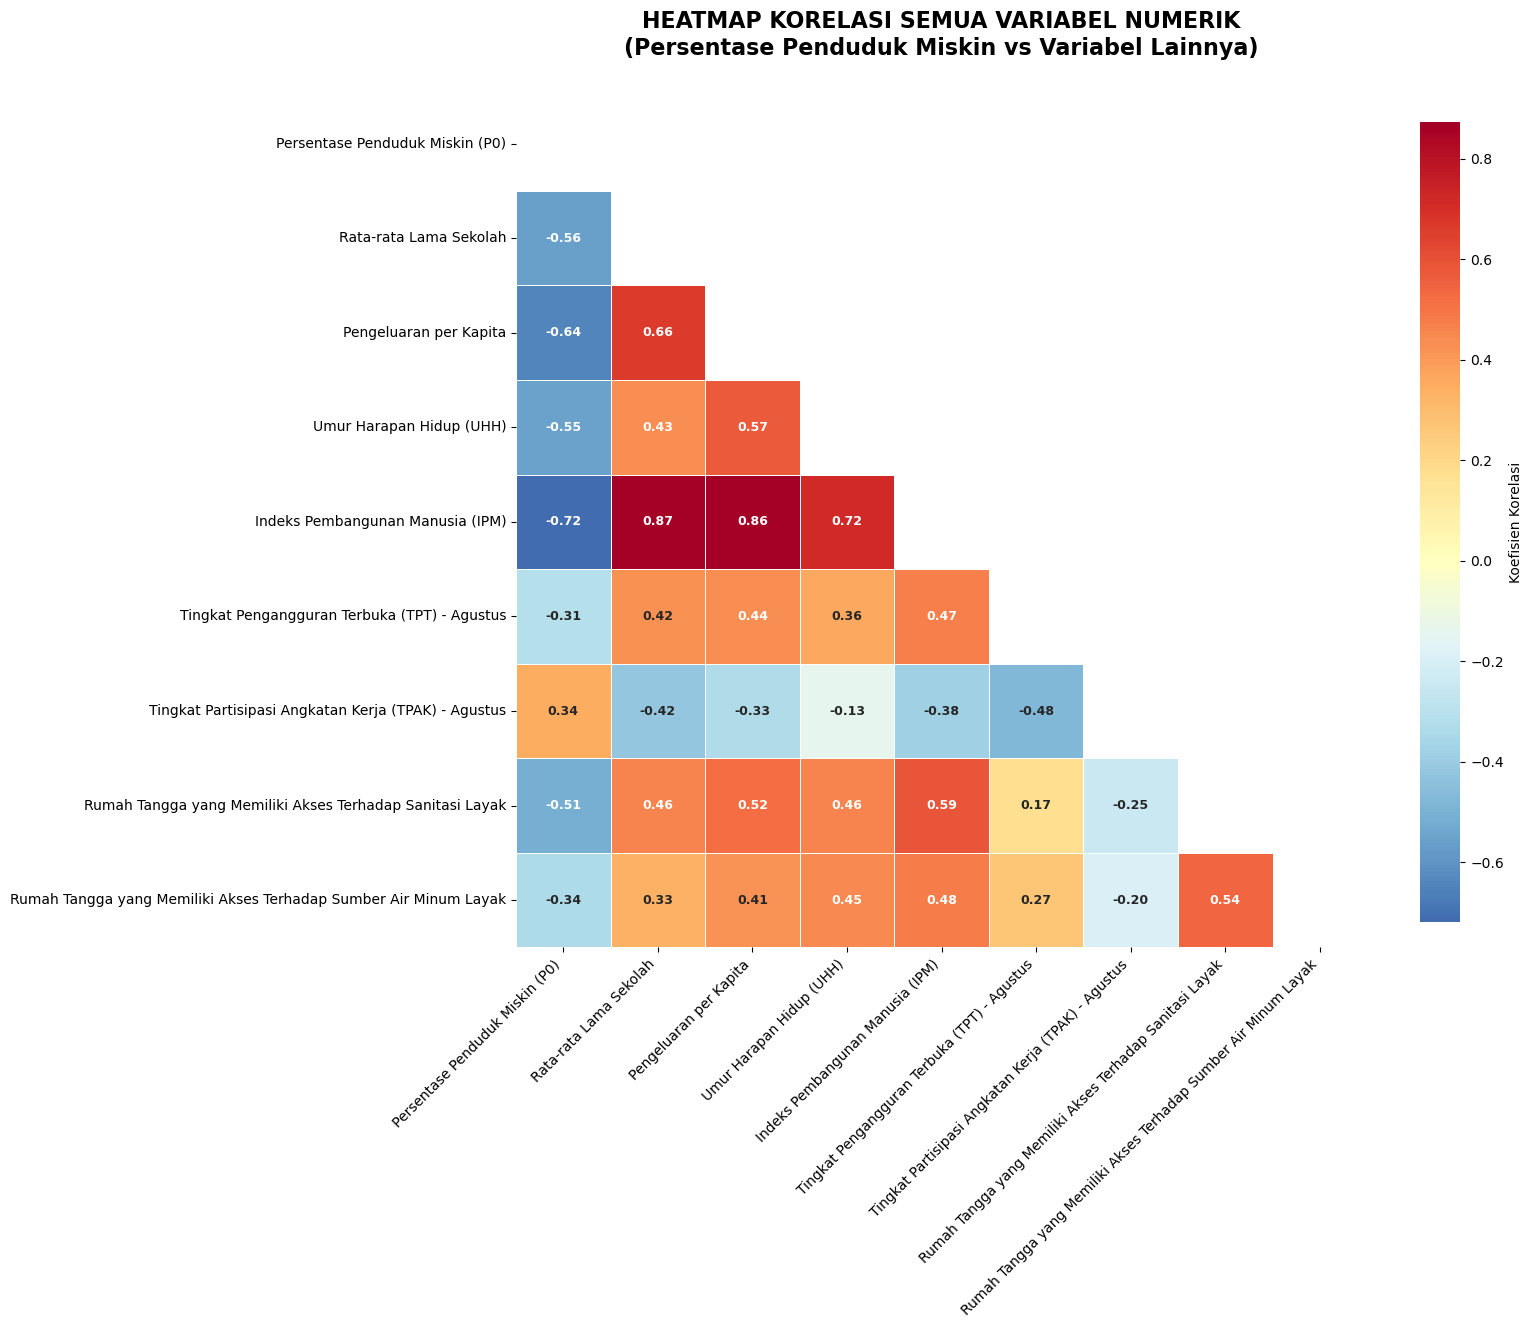

In [34]:

# Hitung matrix korelasi
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

# Buat mask untuk segitiga atas
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            fmt='.2f',
            square=True,
            cbar_kws={"shrink": .8, "label": "Koefisien Korelasi"},
            annot_kws={"size": 9, "weight": "bold"},
            linewidths=0.5,
            linecolor='white')

plt.title('HEATMAP KORELASI SEMUA VARIABEL NUMERIK\n(Persentase Penduduk Miskin vs Variabel Lainnya)', 
          fontsize=16, 
          fontweight='bold', 
          pad=30)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


📈 KORELASI DENGAN TARGET (Persentase Penduduk Miskin):
                                                    Persentase Penduduk Miskin (P0)
Persentase Penduduk Miskin (P0)                                              1.0000
Tingkat Partisipasi Angkatan Kerja (TPAK) - Agu...                           0.3449
Tingkat Pengangguran Terbuka (TPT) - Agustus                                -0.3097
Rumah Tangga yang Memiliki Akses Terhadap Sumbe...                          -0.3384
Rumah Tangga yang Memiliki Akses Terhadap Sanit...                          -0.5146
Umur Harapan Hidup (UHH)                                                    -0.5509
Rata-rata Lama Sekolah                                                      -0.5587
Pengeluaran per Kapita                                                      -0.6423
Indeks Pembangunan Manusia (IPM)                                            -0.7182


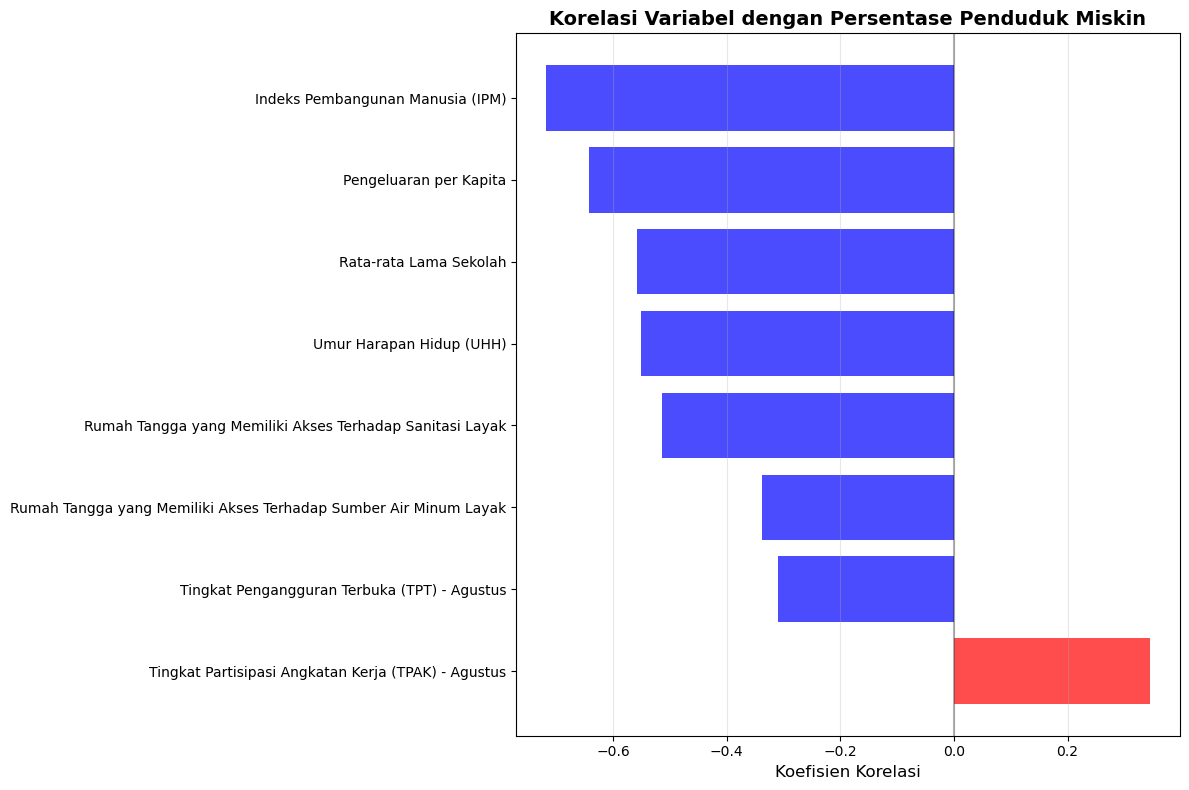

In [35]:
# Analisis korelasi dengan target
print("\n📈 KORELASI DENGAN TARGET (Persentase Penduduk Miskin):")
correlation_with_target = df[numeric_cols].corr()[['Persentase Penduduk Miskin (P0)']].sort_values(
    'Persentase Penduduk Miskin (P0)', ascending=False)

print(correlation_with_target.round(4))

# Visualisasi korelasi dengan target
plt.figure(figsize=(12, 8))
correlation_with_target_filtered = correlation_with_target.drop('Persentase Penduduk Miskin (P0)')
colors = ['red' if x > 0 else 'blue' for x in correlation_with_target_filtered['Persentase Penduduk Miskin (P0)']]

plt.barh(correlation_with_target_filtered.index, 
         correlation_with_target_filtered['Persentase Penduduk Miskin (P0)'],
         color=colors, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Koefisien Korelasi', fontsize=12)
plt.title('Korelasi Variabel dengan Persentase Penduduk Miskin', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# PREPROCESSING DATA

In [36]:

# 1. Encoding Variabel Kategorikal
# print("1. Encoding Variabel Kategorikal...")
from sklearn.calibration import LabelEncoder


label_encoder_provinsi = LabelEncoder()
label_encoder_kabupaten = LabelEncoder()

df['Provinsi_encoded'] = label_encoder_provinsi.fit_transform(df['Provinsi'])
df['Kabupaten_encoded'] = label_encoder_kabupaten.fit_transform(df['Kabupaten/Kota'])

print(f"   Jumlah Provinsi: {len(df['Provinsi'].unique())}")
print(f"   Jumlah Kabupaten/Kota: {len(df['Kabupaten/Kota'].unique())}")

   Jumlah Provinsi: 34
   Jumlah Kabupaten/Kota: 505


In [37]:
# Feature Selection
features = ['Rata-rata Lama Sekolah', 'Pengeluaran per Kapita', 'Umur Harapan Hidup (UHH)',
           'Indeks Pembangunan Manusia (IPM)', 'Tingkat Pengangguran Terbuka (TPT) - Agustus',
           'Tingkat Partisipasi Angkatan Kerja (TPAK) - Agustus',
           'Rumah Tangga yang Memiliki Akses Terhadap Sanitasi Layak',
           'Rumah Tangga yang Memiliki Akses Terhadap Sumber Air Minum Layak',
           'Provinsi_encoded', 'Kabupaten_encoded']

X = df[features]
y = df['Persentase Penduduk Miskin (P0)']

print(f"   Features used: {len(features)}")
print(f"   Features: {features}")

   Features used: 10
   Features: ['Rata-rata Lama Sekolah', 'Pengeluaran per Kapita', 'Umur Harapan Hidup (UHH)', 'Indeks Pembangunan Manusia (IPM)', 'Tingkat Pengangguran Terbuka (TPT) - Agustus', 'Tingkat Partisipasi Angkatan Kerja (TPAK) - Agustus', 'Rumah Tangga yang Memiliki Akses Terhadap Sanitasi Layak', 'Rumah Tangga yang Memiliki Akses Terhadap Sumber Air Minum Layak', 'Provinsi_encoded', 'Kabupaten_encoded']


In [38]:
# Cell 8: Handling Outliers

import numpy as np


import numpy as np
import pandas as pd


def handle_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            np
            # Cap outliers instead of removing
            df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
    return df_clean
pd
# Apply outlier handling
numeric_features = [f for f in features if 'encoded' not in f]
df_clean = handle_outliers_iqr(pd.concat([X, y], axis=1), numeric_features + ['Persentase Penduduk Miskin (P0)'])

X_clean = df_clean[features]
y_clean = df_clean['Persentase Penduduk Miskin (P0)']

print(" Outliers telah ditangani dengan IQR method (capping)")

 Outliers telah ditangani dengan IQR method (capping)


In [39]:
# Cell 9: Feature Scaling dan Splitting Data
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
print(" Feature scaling dengan StandardScaler selesai")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_clean, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

 Feature scaling dengan StandardScaler selesai
Training set: 404 samples
Test set: 101 samples
Number of features: 10


# LINEAR REGRESSION

In [ ]:
# Train Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

# Calculate metrics
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_train_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
train_mae_lr = mean_absolute_error(y_train, y_pred_train_lr)
test_mae_lr = mean_absolute_error(y_test, y_pred_test_lr)
train_r2_lr = r2_score(y_train, y_pred_train_lr)
test_r2_lr = r2_score(y_test, y_pred_test_lr)

# Cross-validation
cv_scores_lr = cross_val_score(lr_model, X_scaled, y_clean, cv=5, scoring='r2')

print("HASIL LINEAR REGRESSION:")
print(f"   R² Score Train:    {train_r2_lr:.4f}")
print(f"   R² Score Test:     {test_r2_lr:.4f}")
print(f"   R² Cross-Validation: {cv_scores_lr.mean():.4f} (±{cv_scores_lr.std() * 2:.4f})")
print(f"   RMSE Train:        {train_rmse_lr:.4f}")
print(f"   RMSE Test:         {test_rmse_lr:.4f}")
print(f"   MAE Train:         {train_mae_lr:.4f}")
print(f"   MAE Test:          {test_mae_lr:.4f}")

# Feature coefficients
lr_coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_,
    'Absolute_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Absolute_Coefficient', ascending=False)

print(lr_coefficients.round(4))

HASIL LINEAR REGRESSION:
   R² Score Train:    0.5083
   R² Score Test:     0.5766
   R² Cross-Validation: 0.0554 (±0.6266)
   RMSE Train:        4.1778
   RMSE Test:         4.2651
   MAE Train:         3.2755
   MAE Test:          3.3570
                                             Feature  Coefficient  \
1                             Pengeluaran per Kapita      -3.0339   
2                           Umur Harapan Hidup (UHH)      -1.8969   
5  Tingkat Partisipasi Angkatan Kerja (TPAK) - Ag...       0.9358   
6  Rumah Tangga yang Memiliki Akses Terhadap Sani...      -0.7591   
3                   Indeks Pembangunan Manusia (IPM)       0.5890   
8                                   Provinsi_encoded      -0.5648   
9                                  Kabupaten_encoded       0.5541   
7  Rumah Tangga yang Memiliki Akses Terhadap Sumb...       0.5523   
4       Tingkat Pengangguran Terbuka (TPT) - Agustus       0.3763   
0                             Rata-rata Lama Sekolah      -0.0635   



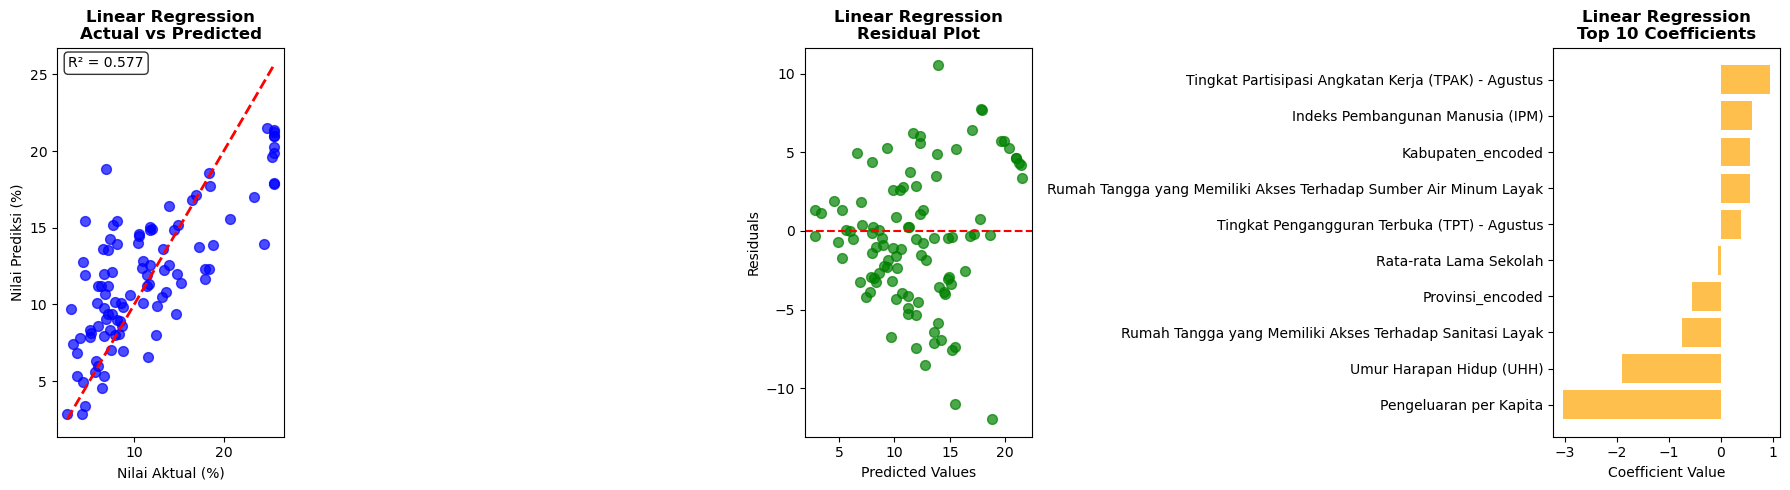

In [41]:
#VISUALISASI LINEAR REGRESSION
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Actual vs Predicted
axes[0].scatter(y_test, y_pred_test_lr, alpha=0.7, color='blue', s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Nilai Aktual (%)')
axes[0].set_ylabel('Nilai Prediksi (%)')
axes[0].set_title('Linear Regression\nActual vs Predicted', fontweight='bold')
axes[0].text(0.05, 0.95, f'R² = {test_r2_lr:.3f}', transform=axes[0].transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Plot 2: Residual Plot
residuals_lr = y_test - y_pred_test_lr
axes[1].scatter(y_pred_test_lr, residuals_lr, alpha=0.7, color='green', s=50)
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Linear Regression\nResidual Plot', fontweight='bold')

# Plot 3: Top Coefficients
top_coeff = lr_coefficients.head(10).sort_values('Coefficient', ascending=True)
axes[2].barh(top_coeff['Feature'], top_coeff['Coefficient'], color='orange', alpha=0.7)
axes[2].set_title('Linear Regression\nTop 10 Coefficients', fontweight='bold')
axes[2].set_xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

# RANDOM FOREST

In [ ]:

# Train Random Forest
from sklearn.base import r2_score


rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Calculate metrics
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
train_mae_rf = mean_absolute_error(y_train, y_pred_train_rf)
test_mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
train_r2_rf = r2_score(y_train, y_pred_train_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)

# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_scaled, y_clean, cv=5, scoring='r2')

print("HASIL RANDOM FOREST:")
print(f"   R² Score Train:    {train_r2_rf:.4f}")
print(f"   R² Score Test:     {test_r2_rf:.4f}")
print(f"   R² Cross-Validation: {cv_scores_rf.mean():.4f} (±{cv_scores_rf.std() * 2:.4f})")
print(f"   RMSE Train:        {train_rmse_rf:.4f}")
print(f"   RMSE Test:         {test_rmse_rf:.4f}")
print(f"   MAE Train:         {train_mae_rf:.4f}")
print(f"   MAE Test:          {test_mae_rf:.4f}")

# Feature importance
rf_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(rf_importance.round(4))

HASIL RANDOM FOREST:
   R² Score Train:    0.9027
   R² Score Test:     0.6812
   R² Cross-Validation: 0.2535 (±0.2201)
   RMSE Train:        1.8586
   RMSE Test:         3.7005
   MAE Train:         1.4167
   MAE Test:          2.7789
                                             Feature  Importance
3                   Indeks Pembangunan Manusia (IPM)      0.4174
1                             Pengeluaran per Kapita      0.2107
8                                   Provinsi_encoded      0.0790
2                           Umur Harapan Hidup (UHH)      0.0662
9                                  Kabupaten_encoded      0.0474
5  Tingkat Partisipasi Angkatan Kerja (TPAK) - Ag...      0.0396
6  Rumah Tangga yang Memiliki Akses Terhadap Sani...      0.0394
0                             Rata-rata Lama Sekolah      0.0372
4       Tingkat Pengangguran Terbuka (TPT) - Agustus      0.0349
7  Rumah Tangga yang Memiliki Akses Terhadap Sumb...      0.0281


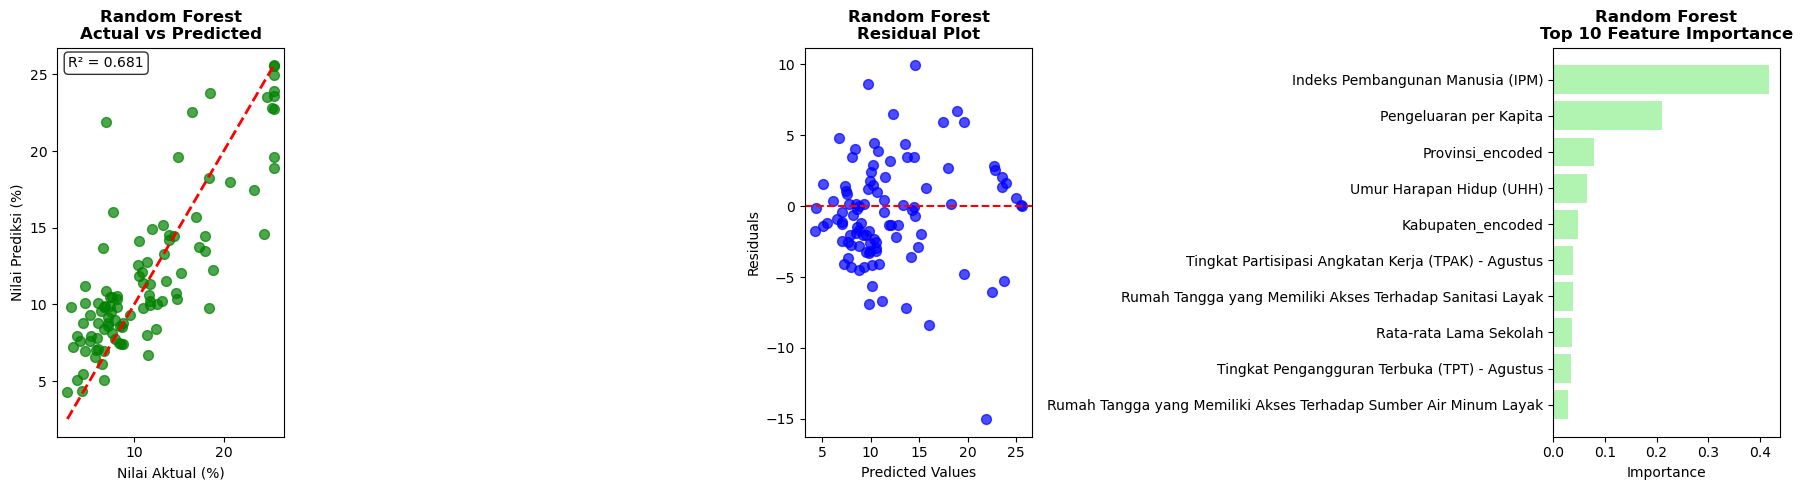

In [43]:
# Visualisasi Random Forest
from matplotlib import pyplot as plt


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Actual vs Predicted
axes[0].scatter(y_test, y_pred_test_rf, alpha=0.7, color='green', s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Nilai Aktual (%)')
axes[0].set_ylabel('Nilai Prediksi (%)')
axes[0].set_title('Random Forest\nActual vs Predicted', fontweight='bold')
axes[0].text(0.05, 0.95, f'R² = {test_r2_rf:.3f}', transform=axes[0].transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Plot 2: Residual Plot
residuals_rf = y_test - y_pred_test_rf
axes[1].scatter(y_pred_test_rf, residuals_rf, alpha=0.7, color='blue', s=50)
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Random Forest\nResidual Plot', fontweight='bold')

# Plot 3: Feature Importance
top_features_rf = rf_importance.head(10).sort_values('Importance', ascending=True)
axes[2].barh(top_features_rf['Feature'], top_features_rf['Importance'], color='lightgreen', alpha=0.7)
axes[2].set_title('Random Forest\nTop 10 Feature Importance', fontweight='bold')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# XGBOOST

In [ ]:

# Train XGBoost
import numpy as np
from sklearn.base import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor


xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

# Calculate metrics
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
train_mae_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
train_r2_xgb = r2_score(y_train, y_pred_train_xgb)
test_r2_xgb = r2_score(y_test, y_pred_test_xgb)

# Cross-validation
cv_scores_xgb = cross_val_score(xgb_model, X_scaled, y_clean, cv=5, scoring='r2')

print("HASIL XGBOOST:")
print(f"   R² Score Train:    {train_r2_xgb:.4f}")
print(f"   R² Score Test:     {test_r2_xgb:.4f}")
print(f"   R² Cross-Validation: {cv_scores_xgb.mean():.4f} (±{cv_scores_xgb.std() * 2:.4f})")
print(f"   RMSE Train:        {train_rmse_xgb:.4f}")
print(f"   RMSE Test:         {test_rmse_xgb:.4f}")
print(f"   MAE Train:         {train_mae_xgb:.4f}")
print(f"   MAE Test:          {test_mae_xgb:.4f}")

# Feature importance
print("\nFEATURE IMPORTANCE XGBOOST:")
xgb_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(xgb_importance.round(4))

HASIL XGBOOST:
   R² Score Train:    0.9893
   R² Score Test:     0.6576
   R² Cross-Validation: 0.1852 (±0.2703)
   RMSE Train:        0.6161
   RMSE Test:         3.8353
   MAE Train:         0.4523
   MAE Test:          2.8190

FEATURE IMPORTANCE XGBOOST:
                                             Feature  Importance
3                   Indeks Pembangunan Manusia (IPM)      0.5686
1                             Pengeluaran per Kapita      0.1040
8                                   Provinsi_encoded      0.1006
9                                  Kabupaten_encoded      0.0452
6  Rumah Tangga yang Memiliki Akses Terhadap Sani...      0.0442
2                           Umur Harapan Hidup (UHH)      0.0392
7  Rumah Tangga yang Memiliki Akses Terhadap Sumb...      0.0294
4       Tingkat Pengangguran Terbuka (TPT) - Agustus      0.0259
5  Tingkat Partisipasi Angkatan Kerja (TPAK) - Ag...      0.0243
0                             Rata-rata Lama Sekolah      0.0186


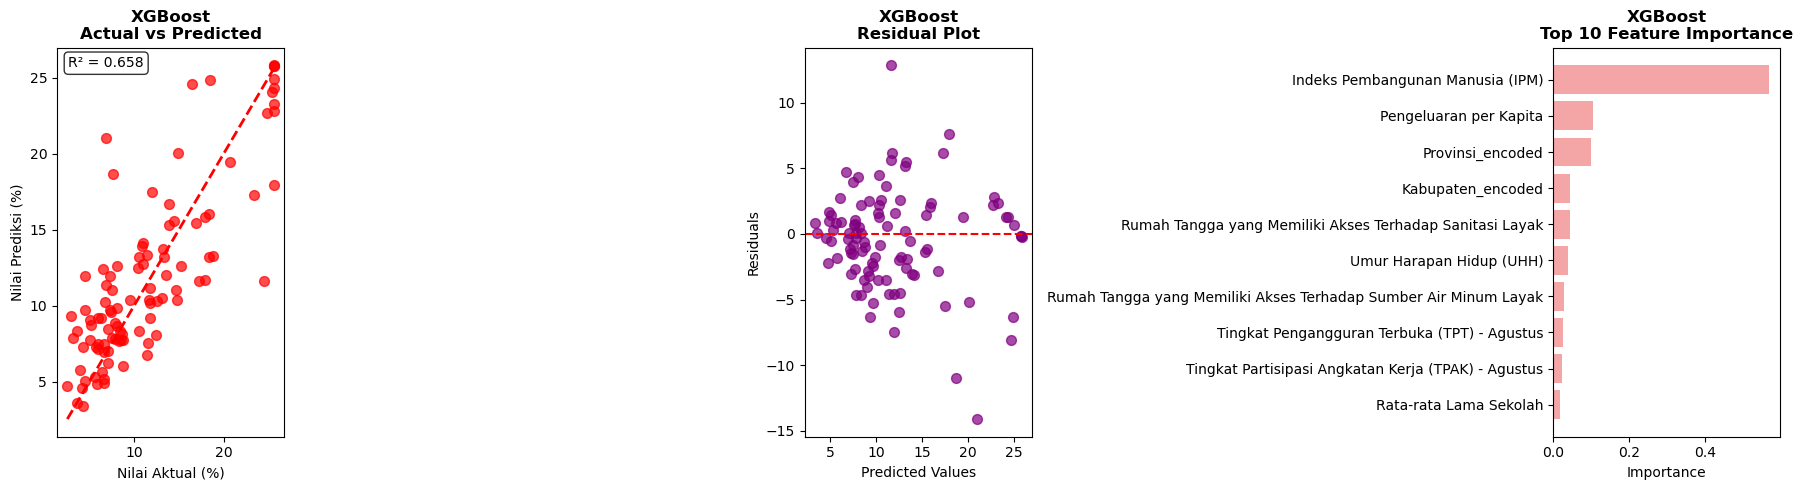

In [45]:
# Visualisasi XGBoost
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Actual vs Predicted
axes[0].scatter(y_test, y_pred_test_xgb, alpha=0.7, color='red', s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Nilai Aktual (%)')
axes[0].set_ylabel('Nilai Prediksi (%)')
axes[0].set_title('XGBoost\nActual vs Predicted', fontweight='bold')
axes[0].text(0.05, 0.95, f'R² = {test_r2_xgb:.3f}', transform=axes[0].transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Plot 2: Residual Plot
residuals_xgb = y_test - y_pred_test_xgb
axes[1].scatter(y_pred_test_xgb, residuals_xgb, alpha=0.7, color='purple', s=50)
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('XGBoost\nResidual Plot', fontweight='bold')

# Plot 3: Feature Importance
top_features_xgb = xgb_importance.head(10).sort_values('Importance', ascending=True)
axes[2].barh(top_features_xgb['Feature'], top_features_xgb['Importance'], color='lightcoral', alpha=0.7)
axes[2].set_title('XGBoost\nTop 10 Feature Importance', fontweight='bold')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# PERBANDINGAN ALGORITMA

In [46]:

comparison_data = {
    'Algorithm': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Test_R2': [test_r2_lr, test_r2_rf, test_r2_xgb],
    'Test_RMSE': [test_rmse_lr, test_rmse_rf, test_rmse_xgb],
    'Test_MAE': [test_mae_lr, test_mae_rf, test_mae_xgb],
    'CV_R2_Mean': [cv_scores_lr.mean(), cv_scores_rf.mean(), cv_scores_xgb.mean()],
    'CV_R2_Std': [cv_scores_lr.std(), cv_scores_rf.std(), cv_scores_xgb.std()]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test_R2', ascending=False)

print("PERBANDINGAN PERFORMANSI ALGORITMA:")
print(comparison_df.round(4))

PERBANDINGAN PERFORMANSI ALGORITMA:
           Algorithm  Test_R2  Test_RMSE  Test_MAE  CV_R2_Mean  CV_R2_Std
1      Random Forest   0.6812     3.7005    2.7789      0.2535     0.1100
2            XGBoost   0.6576     3.8353    2.8190      0.1852     0.1352
0  Linear Regression   0.5766     4.2651    3.3570      0.0554     0.3133


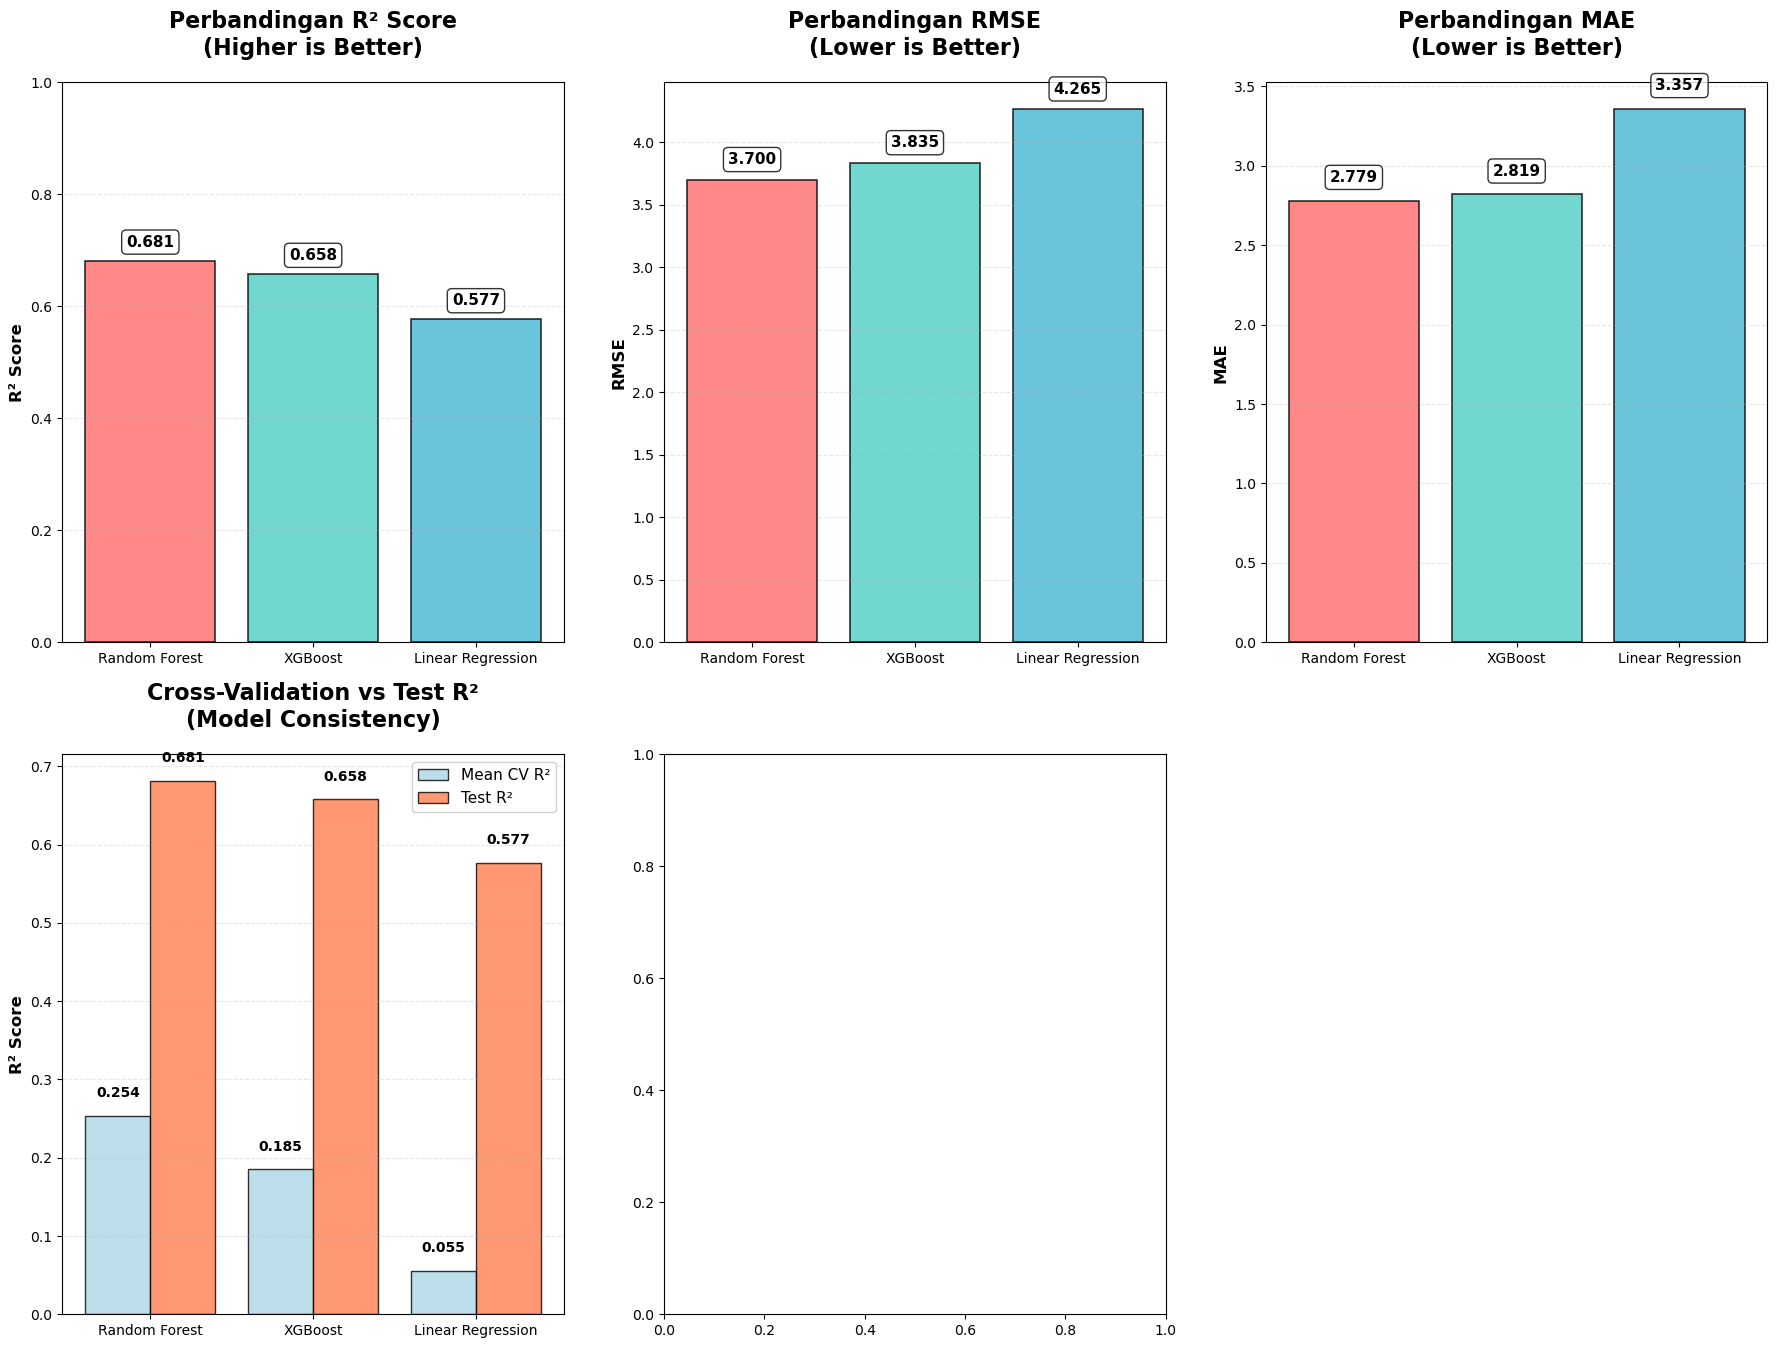

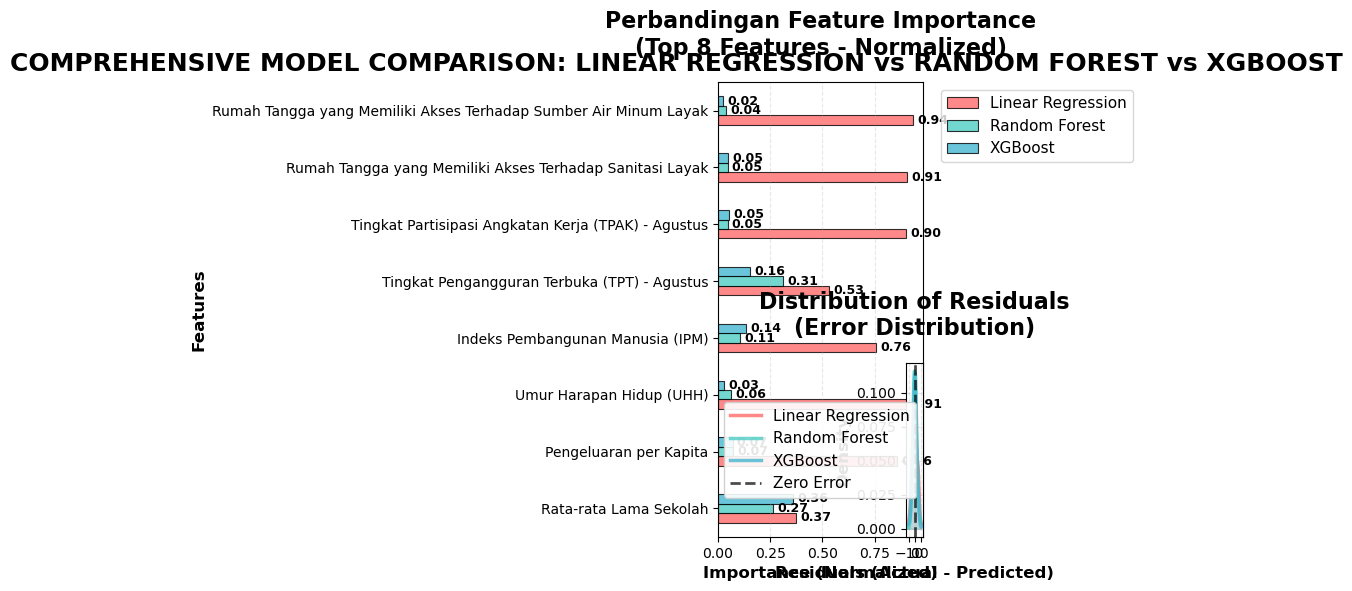


SUMMARY PERFORMANSI MODEL
        Algorithm  Test_R2  Test_RMSE  Test_MAE  CV_R2_Mean  CV_R2_Std  Rank
    Random Forest   0.6812     3.7005    2.7789      0.2535   0.110045     1
          XGBoost   0.6576     3.8353    2.8190      0.1852   0.135167     2
Linear Regression   0.5766     4.2651    3.3570      0.0554   0.313305     3

🏆 MODEL TERBAIK: Random Forest
   R² Score: 0.6812 | RMSE: 3.7005 | MAE: 2.7789
   Cross-Validation Consistency: 0.2535

📊 INSIGHTS:
- Model Random Forest menjelaskan 68.1% variasi data
- Error prediksi rata-rata: ±3.70%
- Konsistensi cross-validation: 0.2535
- 3 Fitur paling penting: Rata-rata Lama Sekolah, Pengeluaran per Kapita, Umur Harapan Hidup (UHH)


In [50]:

# fig = plt.figure(figsize=(20, 12))

# # 1. Perbandingan R² Score
# plt.subplot(2, 3, 1)
# colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
# bars = plt.bar(comparison_df['Algorithm'], comparison_df['Test_R2'], color=colors, alpha=0.8)
# plt.title('Perbandingan R² Score', fontsize=14, fontweight='bold')
# plt.ylabel('R² Score')
# plt.ylim(0, 1)
# for bar, value in zip(bars, comparison_df['Test_R2']):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
#              f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# # 2. Perbandingan RMSE
# plt.subplot(2, 3, 2)
# bars = plt.bar(comparison_df['Algorithm'], comparison_df['Test_RMSE'], color=colors, alpha=0.8)
# plt.title('Perbandingan RMSE', fontsize=14, fontweight='bold')
# plt.ylabel('RMSE')
# for bar, value in zip(bars, comparison_df['Test_RMSE']):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
#              f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# # 3. Perbandingan MAE
# plt.subplot(2, 3, 3)
# bars = plt.bar(comparison_df['Algorithm'], comparison_df['Test_MAE'], color=colors, alpha=0.8)
# plt.title('Perbandingan MAE', fontsize=14, fontweight='bold')
# plt.ylabel('MAE')
# for bar, value in zip(bars, comparison_df['Test_MAE']):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
#              f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# # 4. Cross-Validation vs Test R²
# plt.subplot(2, 3, 4)
# x_pos = np.arange(len(comparison_df['Algorithm']))
# plt.bar(x_pos - 0.2, comparison_df['CV_R2_Mean'], width=0.4, label='Mean CV R²', color='lightblue', alpha=0.8)
# plt.bar(x_pos + 0.2, comparison_df['Test_R2'], width=0.4, label='Test R²', color='coral', alpha=0.8)
# plt.xticks(x_pos, comparison_df['Algorithm'])
# plt.title('Cross-Validation vs Test R²', fontsize=14, fontweight='bold')
# plt.ylabel('R² Score')
# plt.legend()

# # 5. Feature Importance Comparison
# plt.subplot(2, 3, 5)
# importance_comparison = pd.DataFrame({
#     'Feature': features,
#     'Linear Regression': lr_coefficients.set_index('Feature')['Absolute_Coefficient'],
#     'Random Forest': rf_importance.set_index('Feature')['Importance'],
#     'XGBoost': xgb_importance.set_index('Feature')['Importance']
# })

# # Normalisasi
# importance_comparison[['Linear Regression', 'Random Forest', 'XGBoost']] = \
#     importance_comparison[['Linear Regression', 'Random Forest', 'XGBoost']].apply(lambda x: x/x.sum(), axis=1)

# importance_comparison = importance_comparison.head(8)  # Ambil 8 fitur teratas

# importance_comparison.set_index('Feature').plot(kind='barh', figsize=(10, 6), 
#                                               color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
# plt.title('Perbandingan Feature Importance\n(Normalized)', fontsize=14, fontweight='bold')
# plt.xlabel('Importance (Normalized)')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# # 6. Residual Distribution
# plt.subplot(2, 3, 6)
# residuals_all = [residuals_lr, residuals_rf, residuals_xgb]
# labels = ['Linear Regression', 'Random Forest', 'XGBoost']
# colors_residuals = ['blue', 'green', 'red']

# for i, (residual, label, color) in enumerate(zip(residuals_all, labels, colors_residuals)):
#     plt.hist(residual, alpha=0.6, label=label, color=color, bins=20, density=True)

# plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
# plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
# plt.xlabel('Residuals')
# plt.ylabel('Density')
# plt.legend()

# plt.tight_layout()
# plt.show()
# Create a professional comparison visualization
fig = plt.figure(figsize=(22, 16))

# Define consistent colors and styles
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
model_colors = {'Linear Regression': '#FF6B6B', 'Random Forest': '#4ECDC4', 'XGBoost': '#45B7D1'}
residual_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# 1. Perbandingan R² Score
plt.subplot(2, 3, 1)
bars = plt.bar(comparison_df['Algorithm'], comparison_df['Test_R2'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
plt.title('Perbandingan R² Score\n(Higher is Better)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('R² Score', fontsize=12, fontweight='bold')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value annotations with better positioning
for bar, value in zip(bars, comparison_df['Test_R2']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 2. Perbandingan RMSE
plt.subplot(2, 3, 2)
bars = plt.bar(comparison_df['Algorithm'], comparison_df['Test_RMSE'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
plt.title('Perbandingan RMSE\n(Lower is Better)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('RMSE', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')

for bar, value in zip(bars, comparison_df['Test_RMSE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.3f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 3. Perbandingan MAE
plt.subplot(2, 3, 3)
bars = plt.bar(comparison_df['Algorithm'], comparison_df['Test_MAE'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
plt.title('Perbandingan MAE\n(Lower is Better)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('MAE', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')

for bar, value in zip(bars, comparison_df['Test_MAE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.3f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 4. Cross-Validation vs Test R²
plt.subplot(2, 3, 4)
x_pos = np.arange(len(comparison_df['Algorithm']))
bar1 = plt.bar(x_pos - 0.2, comparison_df['CV_R2_Mean'], width=0.4, 
               label='Mean CV R²', color='lightblue', alpha=0.8, edgecolor='black')
bar2 = plt.bar(x_pos + 0.2, comparison_df['Test_R2'], width=0.4, 
               label='Test R²', color='coral', alpha=0.8, edgecolor='black')

plt.xticks(x_pos, comparison_df['Algorithm'])
plt.title('Cross-Validation vs Test R²\n(Model Consistency)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('R² Score', fontsize=12, fontweight='bold')
plt.legend(fontsize=11, framealpha=0.9)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value annotations for both bars
for i, (cv_val, test_val) in enumerate(zip(comparison_df['CV_R2_Mean'], comparison_df['Test_R2'])):
    plt.text(x_pos[i] - 0.2, cv_val + 0.02, f'{cv_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(x_pos[i] + 0.2, test_val + 0.02, f'{test_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. Feature Importance Comparison
plt.subplot(2, 3, 5)
importance_comparison = pd.DataFrame({
    'Feature': features,
    'Linear Regression': lr_coefficients.set_index('Feature')['Absolute_Coefficient'],
    'Random Forest': rf_importance.set_index('Feature')['Importance'],
    'XGBoost': xgb_importance.set_index('Feature')['Importance']
})

# Normalisasi dan ambil 8 fitur teratas berdasarkan rata-rata importance
importance_comparison[['Linear Regression', 'Random Forest', 'XGBoost']] = \
    importance_comparison[['Linear Regression', 'Random Forest', 'XGBoost']].apply(lambda x: x/x.sum(), axis=1)

# Calculate mean importance for sorting
importance_comparison['Mean_Importance'] = importance_comparison[['Linear Regression', 'Random Forest', 'XGBoost']].mean(axis=1)
importance_comparison = importance_comparison.nlargest(8, 'Mean_Importance')

# Create horizontal bar plot
ax = importance_comparison.set_index('Feature')[['Linear Regression', 'Random Forest', 'XGBoost']].plot(
    kind='barh', 
    color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
    alpha=0.8,
    edgecolor='black',
    linewidth=0.8,
    figsize=(10, 6)
)

plt.title('Perbandingan Feature Importance\n(Top 8 Features - Normalized)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Importance (Normalized)', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add value annotations on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9, fontweight='bold')

# 6. Residual Distribution
plt.subplot(2, 3, 6)
residuals_all = [residuals_lr, residuals_rf, residuals_xgb]
labels = ['Linear Regression', 'Random Forest', 'XGBoost']

# Create density plot instead of histogram
for i, (residual, label, color) in enumerate(zip(residuals_all, labels, residual_colors)):
    # Use kernel density estimation for smoother plots
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(residual)
    x_range = np.linspace(min(residual), max(residual), 100)
    plt.plot(x_range, kde(x_range), label=label, color=color, linewidth=2.5, alpha=0.8)
    plt.fill_between(x_range, kde(x_range), alpha=0.2, color=color)

plt.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Zero Error')
plt.title('Distribution of Residuals\n(Error Distribution)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.legend(fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')

# Add overall title
plt.suptitle('COMPREHENSIVE MODEL COMPARISON: LINEAR REGRESSION vs RANDOM FOREST vs XGBOOST', 
             fontsize=18, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Display performance summary table
print("\n" + "="*80)
print("SUMMARY PERFORMANSI MODEL")
print("="*80)

summary_table = comparison_df.copy()
summary_table['Test_R2'] = summary_table['Test_R2'].round(4)
summary_table['Test_RMSE'] = summary_table['Test_RMSE'].round(4)
summary_table['Test_MAE'] = summary_table['Test_MAE'].round(4)
summary_table['CV_R2_Mean'] = summary_table['CV_R2_Mean'].round(4)

# Add ranking
summary_table['Rank'] = summary_table['Test_R2'].rank(ascending=False).astype(int)
summary_table = summary_table.sort_values('Rank')

print(summary_table.to_string(index=False))

# Best model highlight
best_model = summary_table.iloc[0]
print(f"\n🏆 MODEL TERBAIK: {best_model['Algorithm']}")
print(f"   R² Score: {best_model['Test_R2']:.4f} | RMSE: {best_model['Test_RMSE']:.4f} | MAE: {best_model['Test_MAE']:.4f}")
print(f"   Cross-Validation Consistency: {best_model['CV_R2_Mean']:.4f}")

# Additional insights
print(f"\n📊 INSIGHTS:")
print(f"- Model {best_model['Algorithm']} menjelaskan {best_model['Test_R2']*100:.1f}% variasi data")
print(f"- Error prediksi rata-rata: ±{best_model['Test_RMSE']:.2f}%")
print(f"- Konsistensi cross-validation: {best_model['CV_R2_Mean']:.4f}")

# Feature importance insights
top_features = importance_comparison.nlargest(3, 'Mean_Importance')['Feature'].tolist()
print(f"- 3 Fitur paling penting: {', '.join(top_features)}")

In [ ]:
# Cell 18: Simpan Model dan Buat Fungsi Prediksi
import joblib


print("\n" + "=" * 60)
print("STEP 8: IMPLEMENTASI UNTUK STREAMLIT")
print("=" * 60)

# Pilih model terbaik berdasarkan R² score
best_model_name = comparison_df.iloc[0]['Algorithm']
if best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
else:
    best_model = xgb_model

# Simpan model dan preprocessing objects
model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'label_encoder_provinsi': label_encoder_provinsi,
    'label_encoder_kabupaten': label_encoder_kabupaten,
    'features': features,
    'performance': comparison_df.iloc[0].to_dict()
}

# Simpan ke file
joblib.dump(model_artifacts, 'poverty_prediction_model.pkl')
print(f"✅ Model terbaik ({best_model_name}) dan artifacts telah disimpan!")


STEP 8: IMPLEMENTASI UNTUK STREAMLIT
✅ Model terbaik (Random Forest) dan artifacts telah disimpan!


In [49]:
# Cell 19: Fungsi Prediksi untuk Streamlit
def predict_poverty_rate(input_data, model_artifacts):
    """
    Memprediksi persentase penduduk miskin berdasarkan input data
    
    Parameters:
    input_data (dict): Dictionary berisi nilai untuk semua feature
    model_artifacts (dict): Dictionary berisi model dan preprocessing objects
    
    Returns:
    float: Prediksi persentase penduduk miskin
    """
    # Extract artifacts
    model = model_artifacts['model']
    scaler = model_artifacts['scaler']
    le_provinsi = model_artifacts['label_encoder_provinsi']
    le_kabupaten = model_artifacts['label_encoder_kabupaten']
    features = model_artifacts['features']
    
    # Preprocess input data
    input_df = pd.DataFrame([input_data])
    
    # Encode provinsi dan kabupaten
    if 'Provinsi' in input_df.columns:
        input_df['Provinsi_encoded'] = le_provinsi.transform(input_df['Provinsi'])
    if 'Kabupaten/Kota' in input_df.columns:
        input_df['Kabupaten_encoded'] = le_kabupaten.transform(input_df['Kabupaten/Kota'])
    
    # Pastikan semua feature ada
    for feature in features:
        if feature not in input_df.columns:
            raise ValueError(f"Feature {feature} tidak ditemukan dalam input data")
    
    # Urutkan kolom sesuai dengan features
    input_processed = input_df[features]
    
    # Scale features
    input_scaled = scaler.transform(input_processed)
    
    # Predict
    prediction = model.predict(input_scaled)[0]
    
    return prediction

print("✅ Fungsi predict_poverty_rate() telah dibuat!")

✅ Fungsi predict_poverty_rate() telah dibuat!
